### 1. 분석의 개요 및 목적

- Toyota Corolla model의 다양한 사양과 옵션에 따른 중고차 가격을 분석해 회귀식을 만들고, 
  주어진 test set 내 중고차 가격을 예측해본다. 

### 2. 분석의 방법 및 범위

- 분석 범위: 주어진 train set 내 1019개의 중고차들의 38개의 변수.  
- 분석 방법
  1. 독립변수(independent) X, 종속변수(dependent) Y 결정. (본 프로젝트의 경우, Y는 Price로 결정)
  2. 독립변수를 연속형(continous), 이산형(descrete), 질적(categorical) 변수로 나눔
  3. Linear Regression 독립변수, 종속변수 모두 측정형 변수. (연속형은 모두 측정형 변수, 이산형 중의 일부는 측정형 변수)
  4. 독립변수, 종속변수 간 & 독립변수 서로간 상관 정도 분석
  5. 회귀식에 반영할 최종 독립변수 X 선정. 
     (if needed, 변수 간 조합으로 새로운 변수 만들어 회귀식에 반영)

In [2]:
%matplotlib inline
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
from statsmodels.graphics.regressionplots import *
from sklearn.cross_validation import train_test_split
import math
import statsmodels.stats as stats 
import numpy as np
import pandas as pd
import scipy.stats as scipystats
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import sklearn
import sklearn.model_selection
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelBinarizer

### 3. 분석 프로세스

#### (1) 데이터 불러오기

In [3]:
# train set 불러오기 
toyota = pd.read_csv("train.csv")
toyota.tail()

,Id,Model,Price,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
1014,1434,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA AUT3...,8950,71,10,1998,29000,Petrol,86,1,...,0,1,0,0,0,1,0,0,0,0
1015,1438,TOYOTA Corolla 1.3 16V HATCHB G6 2/3-Doors,7500,69,12,1998,20544,Petrol,86,1,...,1,1,0,1,1,1,0,0,0,0
1016,1440,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,8500,71,10,1998,17016,Petrol,86,0,...,0,1,0,0,0,1,0,0,0,0
1017,1441,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,7250,70,11,1998,16916,Petrol,86,1,...,0,0,0,0,0,1,0,0,0,0
1018,1442,TOYOTA Corolla 1.6 LB LINEA TERRA 4/5-Doors,6950,76,5,1998,1,Petrol,110,0,...,0,1,0,0,0,0,0,0,0,0


#### (2) 변수의 구성

In [4]:
toyota.keys()

Index([u'Id', u'Model', u'Price', u'Age_08_04', u'Mfg_Month', u'Mfg_Year',
       u'KM', u'Fuel_Type', u'HP', u'Met_Color', u'Color', u'Automatic', u'CC',
       u'Doors', u'Cylinders', u'Gears', u'Quarterly_Tax', u'Weight',
       u'Mfr_Guarantee', u'BOVAG_Guarantee', u'Guarantee_Period', u'ABS',
       u'Airbag_1', u'Airbag_2', u'Airco', u'Automatic_airco',
       u'Boardcomputer', u'CD_Player', u'Central_Lock', u'Powered_Windows',
       u'Power_Steering', u'Radio', u'Mistlamps', u'Sport_Model',
       u'Backseat_Divider', u'Metallic_Rim', u'Radio_cassette',
       u'Parking_Assistant', u'Tow_Bar'],
      dtype='object')

In [5]:
toyota.shape
# 총 변수: 39개, data는 1019개

(1019, 39)

#### (3) 변수 탐색

In [6]:
# Step1. toyota DF을 예측하고자 하는 변수 Price와 독립변수로 보기 어려운 id, model까지 분리해서 독립변수만의 DF dfx와 dfy로 구분
dfy = toyota.iloc[:,:3]
dfx = toyota.iloc[:,3:]
dfy.tail()

,Id,Model,Price
1014,1434,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA AUT3...,8950
1015,1438,TOYOTA Corolla 1.3 16V HATCHB G6 2/3-Doors,7500
1016,1440,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,8500
1017,1441,TOYOTA Corolla 1.3 16V HATCHB LINEA TERRA 2/3-...,7250
1018,1442,TOYOTA Corolla 1.6 LB LINEA TERRA 4/5-Doors,6950


In [7]:
# Step2. 예측하고자 하는 변수 Price의 다름을 파악.
dfy["Price"].describe() 

count     1019.000000
mean     10738.358194
std       3614.987568
min       4350.000000
25%       8400.000000
50%       9850.000000
75%      11950.000000
max      31000.000000
Name: Price, dtype: float64

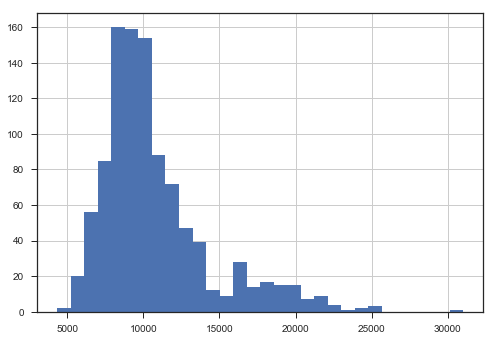

In [8]:
dfy["Price"].hist(bins=30)

In [9]:
dfx.tail() # 독립변수 36개

,Age_08_04,Mfg_Month,Mfg_Year,KM,Fuel_Type,HP,Met_Color,Color,Automatic,CC,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
1014,71,10,1998,29000,Petrol,86,1,Blue,1,1300,...,0,1,0,0,0,1,0,0,0,0
1015,69,12,1998,20544,Petrol,86,1,Blue,0,1300,...,1,1,0,1,1,1,0,0,0,0
1016,71,10,1998,17016,Petrol,86,0,Blue,0,1300,...,0,1,0,0,0,1,0,0,0,0
1017,70,11,1998,16916,Petrol,86,1,Grey,0,1300,...,0,0,0,0,0,1,0,0,0,0
1018,76,5,1998,1,Petrol,110,0,Green,0,1600,...,0,1,0,0,0,0,0,0,0,0


#### (4) 독립 변수 분류

In [10]:
# Step1. 양적 변수(이산형(descrete), 연속형(continous))와 질적 변수(category)로 구분.
# but, Data가 1000개 이상으로 많음 -> 한눈에 구분하기 어렵다.
# 우선 추정으로 임의의 분류를 실시한 뒤, scatter plot (산포도) 그려서 확인

In [18]:
# 연속형 변수 (initial)
con_var = ['Age_08_04', 'KM', 'Weight']

In [19]:
# 이산형 변수 (initial)
des_var = ['CC', 'Doors', 'Cylinders', 'Gears', 'HP', 'Quarterly_Tax', 'Mfg_Month', 'Mfg_Year', 'Guarantee_Period']

In [20]:
# 질적 변수 (initial)
cat_var = ['Fuel_Type', 'Met_Color', 'Color', 'Automatic', 'Mfr_Guarantee', 'BOVAG_Guarantee', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco', 
           'Automatic_airco', 'Boardcomputer','CD_Player', 'Central_Lock', 'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps', 
           'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette', 'Parking_Assistant', 'Tow_Bar']

In [21]:
# Step2. 연속형 변수만의 DataFrame 생성.
dfx_con = dfx[con_var]
dfx_con.head()

,Age_08_04,KM,Weight
0,23,46986,1165
1,23,72937,1165
2,30,38500,1170
3,25,31461,1185
4,25,32189,1185


In [22]:
# 이산형 변수의 value별 개수 확인
dfx_des = dfx[des_var]
for var in des_var:
    print var
    print dfx_des[var].value_counts() 

CC
1600     608
1300     177
1400     114
2000      81
1900      22
1800       9
1598       2
1587       2
1995       1
16000      1
1398       1
1332       1
Name: CC, dtype: int64
Doors
5    486
3    439
4     93
2      1
Name: Doors, dtype: int64
Cylinders
4    1019
Name: Cylinders, dtype: int64
Gears
5    990
6     29
Name: Gears, dtype: int64
HP
110    596
86     177
97     114
72      53
69      25
90      21
107     16
192      7
116      7
98       2
73       1
Name: HP, dtype: int64
Quarterly_Tax
85     446
69     393
185     71
19      49
100     15
64      13
234     12
210      8
197      8
283      1
163      1
72       1
40       1
Name: Quarterly_Tax, dtype: int64
Mfg_Month
1     150
4     105
3     100
2      94
7      93
8      89
6      89
5      88
10     76
9      49
12     43
11     43
Name: Mfg_Month, dtype: int64
Mfg_Year
1999    316
1998    280
2000    155
2001    134
2003     60
2002     59
2004     15
Name: Mfg_Year, dtype: int64
Guarantee_Period
3     902
6  

In [23]:
# 독립변수 중 질적변수만의 DataFrame 생성.
dfx_cat = dfx[cat_var]
dfx_cat.tail()

,Fuel_Type,Met_Color,Color,Automatic,Mfr_Guarantee,BOVAG_Guarantee,ABS,Airbag_1,Airbag_2,Airco,...,Powered_Windows,Power_Steering,Radio,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Radio_cassette,Parking_Assistant,Tow_Bar
1014,Petrol,1,Blue,1,1,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
1015,Petrol,1,Blue,0,1,1,1,1,1,1,...,1,1,0,1,1,1,0,0,0,0
1016,Petrol,0,Blue,0,0,1,0,1,1,0,...,0,1,0,0,0,1,0,0,0,0
1017,Petrol,1,Grey,0,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1018,Petrol,0,Green,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


Age_08_04


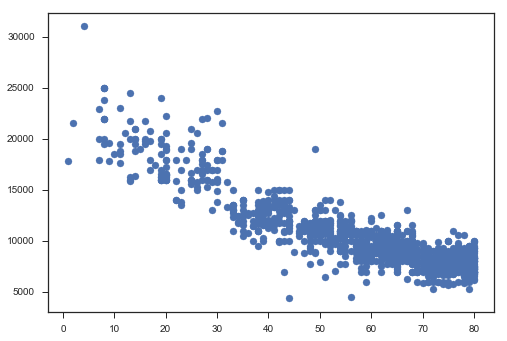

KM


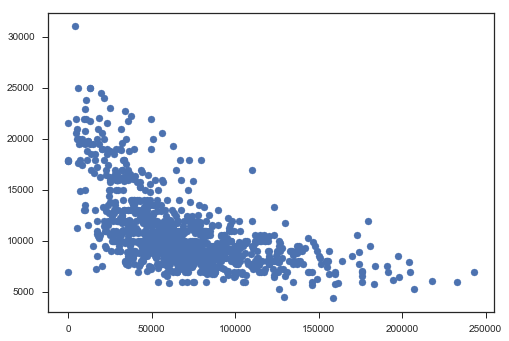

Weight


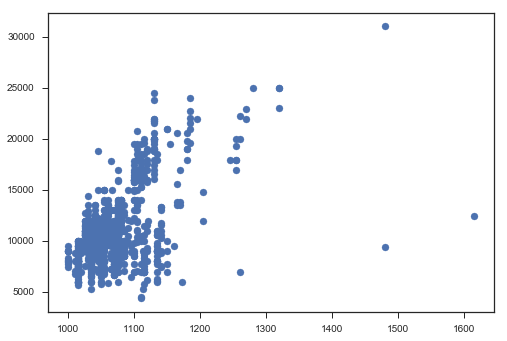

In [24]:
# Step3. 연속형 변수와 종속 변수의 관계 by scatter plot(하나하나씩)
for var in con_var:
    print var
    plt.scatter(dfx_con[var], dfy["Price"])
    plt.show()

CC


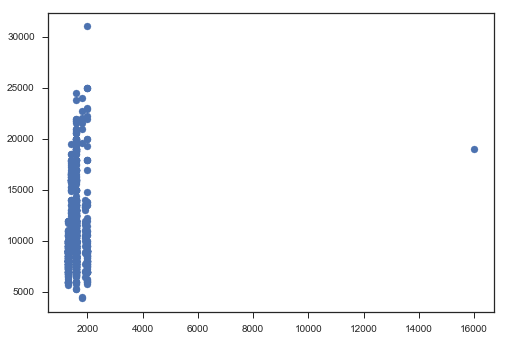

Doors


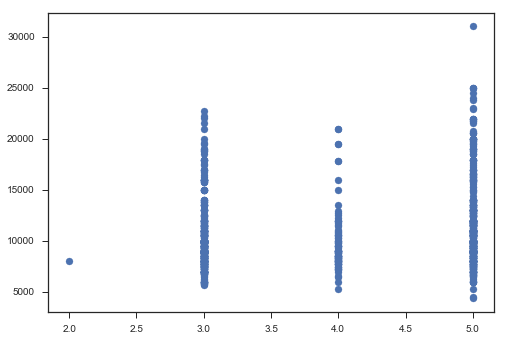

Cylinders


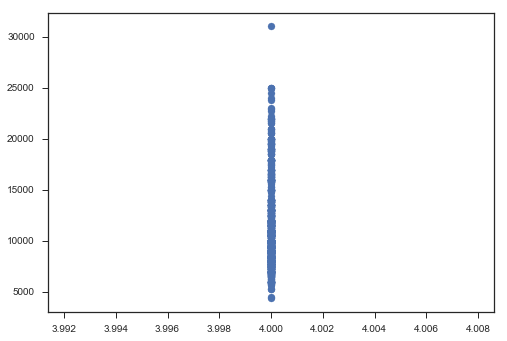

Gears


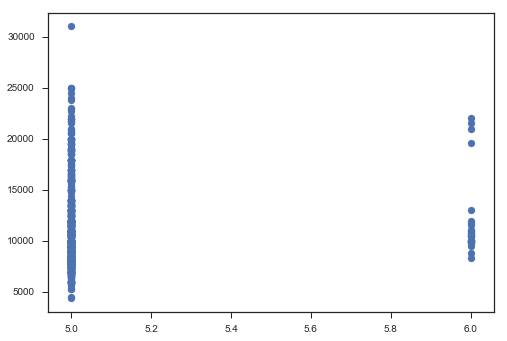

HP


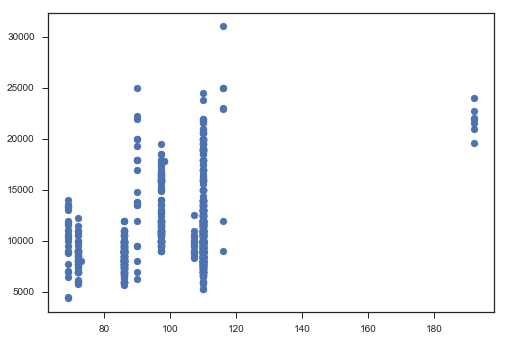

Quarterly_Tax


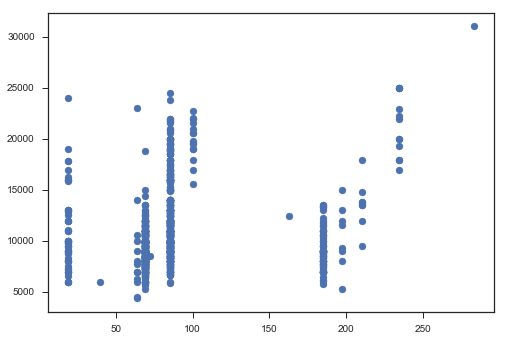

Mfg_Month


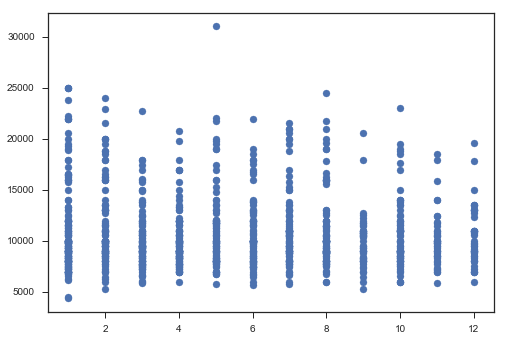

Mfg_Year


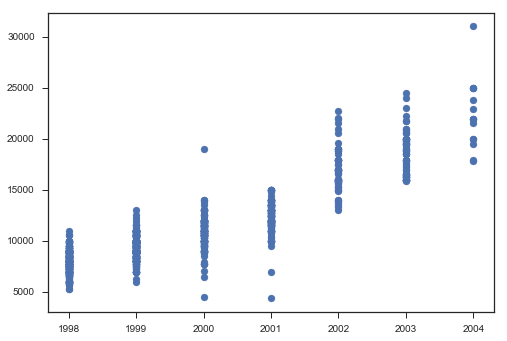

Guarantee_Period


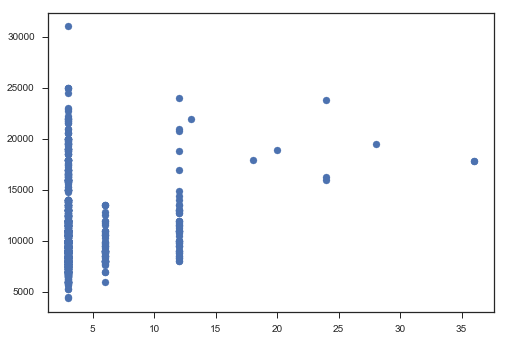

In [25]:
# 이산형 변수와 종속 변수 간 관계 by scatter plot (하나하나씩)
for var in des_var:
    print var
    plt.scatter(dfx_des[var], dfy["Price"])
    plt.show()

In [26]:
# 질적 변수와 종속 변수 간 관계 by box plot (하나하나씩)
def display_boxplot(feature):
    with plt.style.context(('seaborn-whitegrid')):
        sns.boxplot(x=dfx[feature], y=dfy['Price'], linewidth=2, palette="Set1")

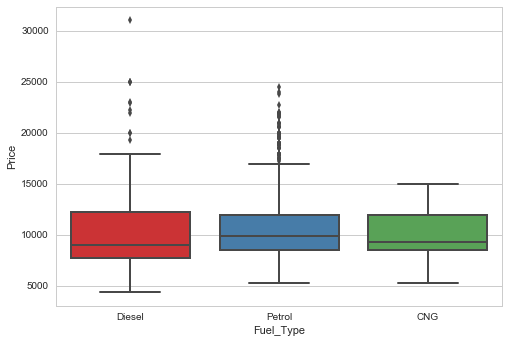

In [27]:
display_boxplot('Fuel_Type')

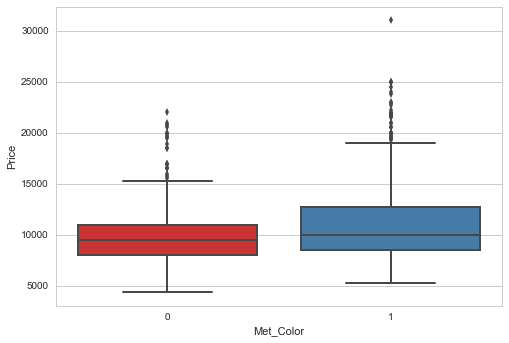

In [28]:
display_boxplot('Met_Color')

In [29]:
# 하나씩 보는 것은 시간 등 많이 소요됨 -> 한눈에 볼 수 있게 출력하는 함수
def display_multi_boxplots(start_feature_name, row, col):
    with plt.style.context(('seaborn-whitegrid')):
        f, axes = plt.subplots(row, col, figsize=(2.3*col, 3.5*row), sharey=True)

        nums = row*col
        start_idx = cat_var.index(start_feature_name)

        for num, ax in zip(range(nums), axes.flat):
            try:
                sns.boxplot(x=dfx[cat_var[start_idx + num]], y=dfy['Price'], palette="Set3", ax=ax)
            except:
                pass

In [30]:
len(cat_var)

24

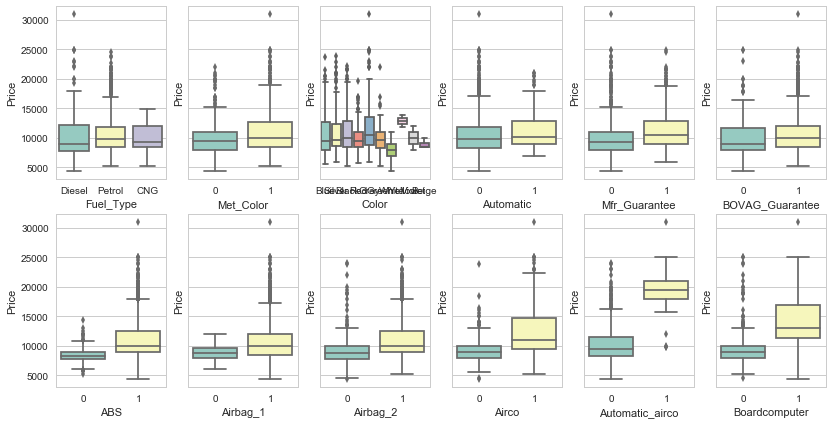

In [31]:
display_multi_boxplots('Fuel_Type', 2, 6)

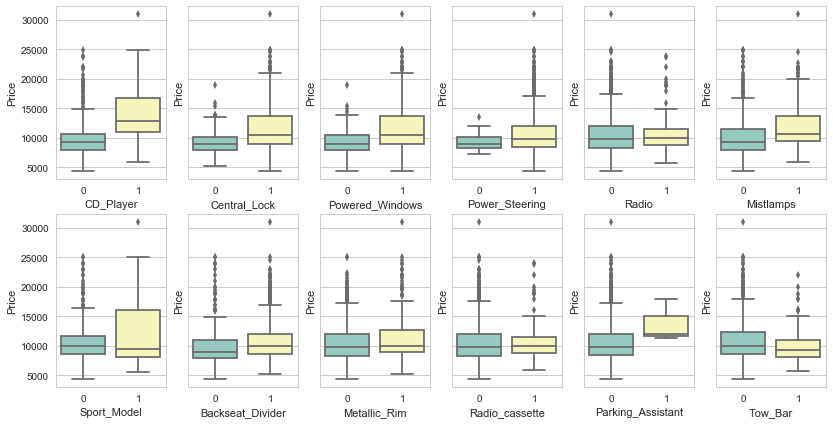

In [32]:
display_multi_boxplots('CD_Player', 2, 6)

In [33]:
# Scatter plot 및 box plot 확인 후
# 'HP' -> 이산형
# 'Age_08_04' -> 연속형
con_var = ['KM', 'Weight', 'Age_08_04']
des_var = ['CC', 'Doors', 'Cylinders', 'Gears', 'Quarterly_Tax', 'Mfg_Month', 'Mfg_Year', 'Guarantee_Period', 'HP']
dfx_con = dfx[con_var]
dfx_des = dfx[des_var]

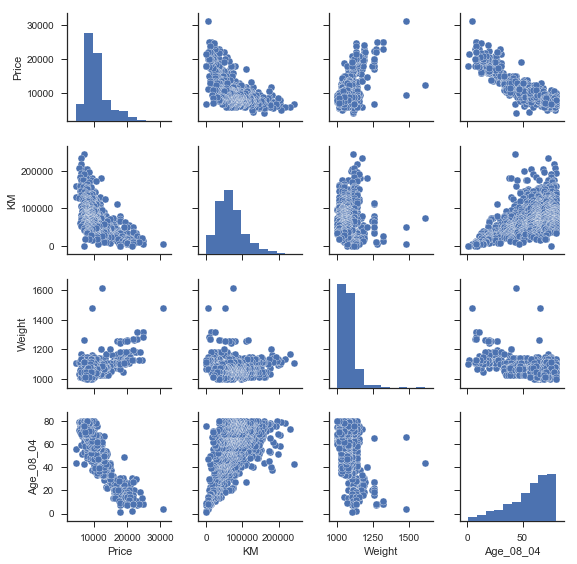

In [34]:
# PairPlot 그려보기.
# dfy의 Price와 dfx의 4개(2개)의 data를 concat으로 결합시킨 후 산포도 그림
with plt.style.context(('seaborn-ticks')):
    sns_plot = sns.pairplot(pd.concat([dfy.Price, dfx_con], axis=1) ,size=2)
    
# 모든 데이터 한번에 pairplot 작성 및 png type으로 저장하는 법 (단점: 오래걸림)
#    sns_plot = sns.pairplot(pd.concat([dfy.Price, dfx_real], axis=1), size=2)
#    sns_plot.savefig("pairplot-real-values.png")

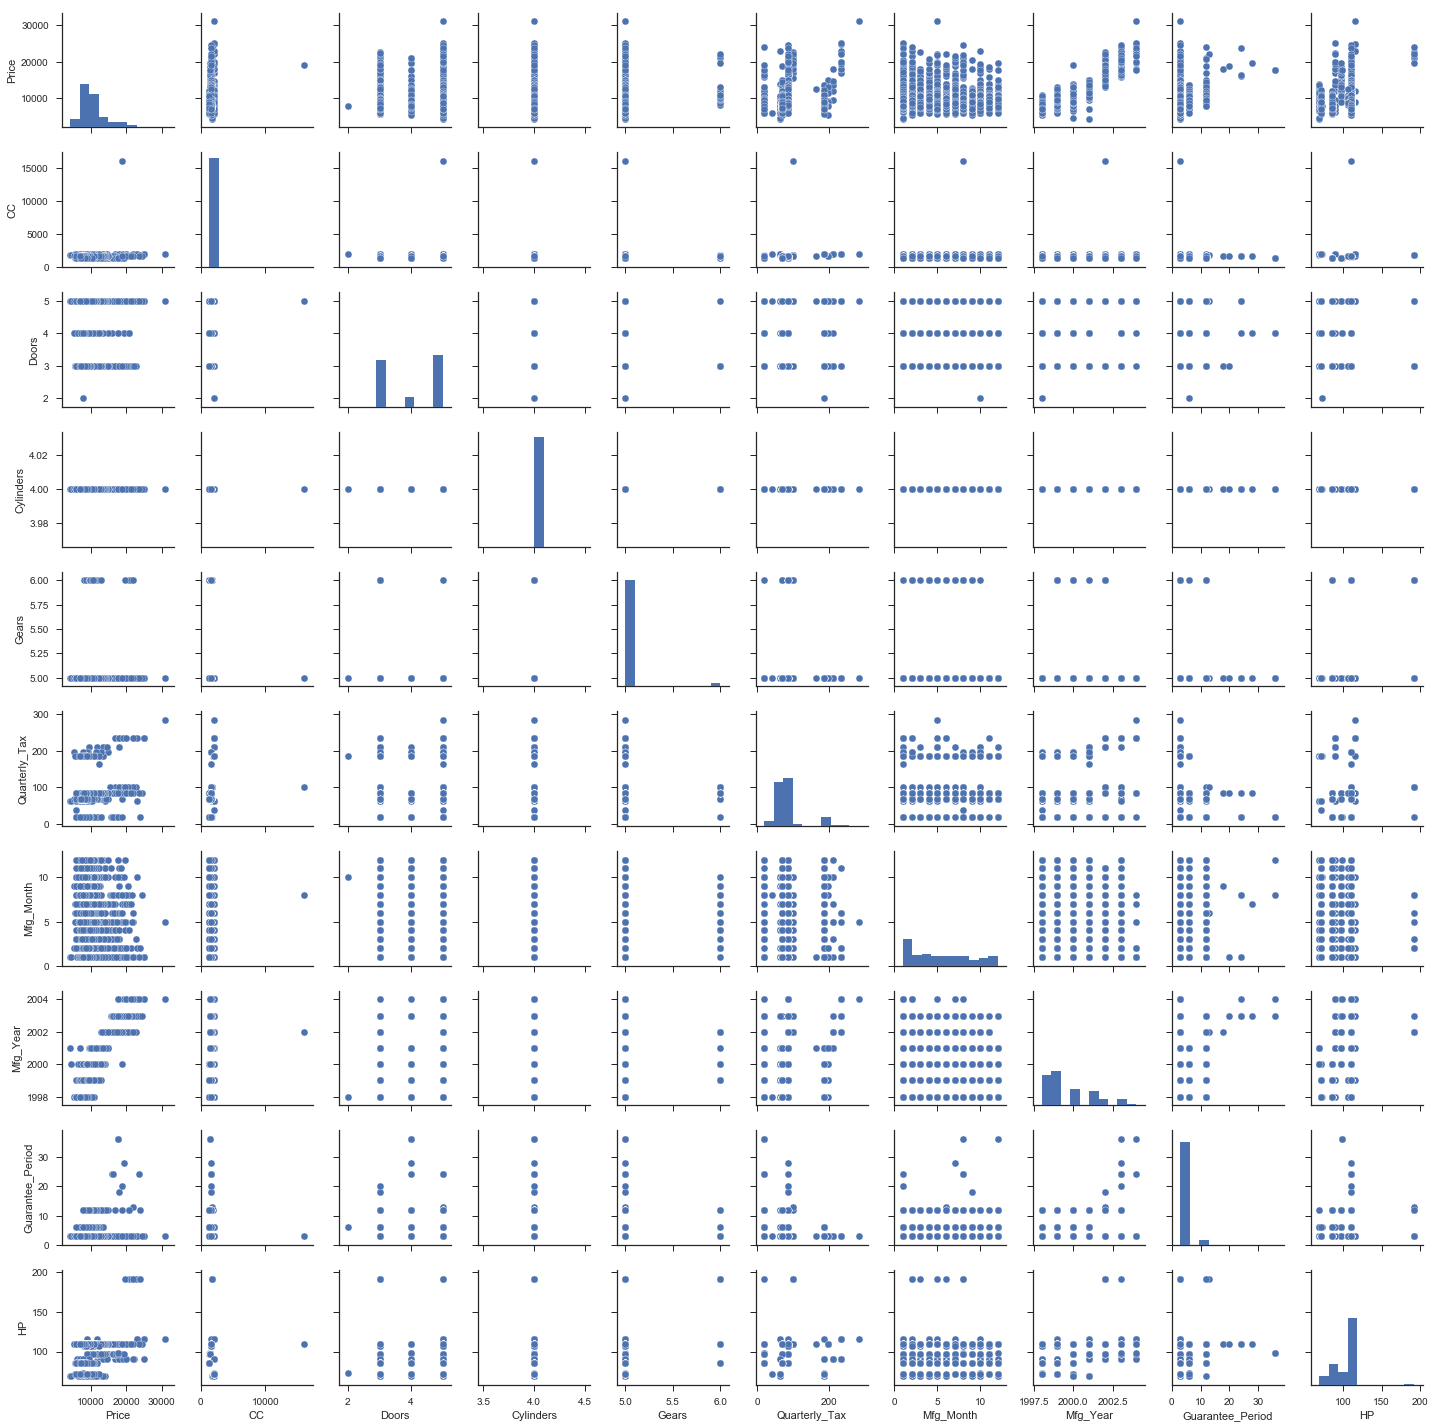

In [35]:
with plt.style.context(('seaborn-ticks')):
    sns_plot = sns.pairplot(pd.concat([dfy.Price, dfx_des], axis=1) ,size=2)

#### 연속형 변수와 종속 변수 Price 간 상관분석
- 두 개의 "양적 자료 간"의 관련성이 있는지를 통계적으로 검정


In [36]:
# Step1. 산포도 그려보기 (위에서 pairplot으로 실시)`
# Step2. 상관계수 확인
corr_matrix = pd.concat([dfy.Price, dfx_con], axis=1) 
corrmat = corr_matrix.corr() #현황만 보는것. 즉, 통계적으로 의미가 있는지 판단할 수 없음.
corrmat

,Price,KM,Weight,Age_08_04
Price,1.000000,-0.575962,0.557015,-0.883900
KM,-0.575962,1.000000,-0.011154,0.516486
Weight,0.557015,-0.011154,1.000000,-0.463990
Age_08_04,-0.883900,0.516486,-0.463990,1.000000


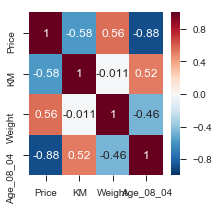

In [37]:
# heatmap
f, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(corrmat, annot=True)

In [38]:
# Step3. Pearson 상관분석 실시 (정규성 만족 가정) - 다시 확인
print scipystats.pearsonr(dfy.Price, dfx.KM)
print scipystats.pearsonr(dfy.Price, dfx.Weight)
print scipystats.pearsonr(dfy.Price, dfx.Age_08_04)
# KM, Weight, Age_08_04 모두 유의수준 0.05에서 pvalue가 각각 0.000 이므로 통계적으로 유의한 상관관계가 있음.

(-0.57596185216445739, 4.2103663413920063e-91)
(0.55701487105264824, 4.1793981498584848e-84)
(-0.88389997596143111, 0.0)


#### 이산형 변수, 질적 변수 - 독립 표본 T검정 or 분산분석 
- 값이 2개인 경우? 독립 표본 T검정
- 값이 3개 이상인 경우? 분산분석
- 값의 차이 따른 종속 변수 Price의 평균의 차이를 보기 위함

In [39]:
# Step1. Unique value 확인
df = pd.concat([dfx_des, dfx_cat], axis=1) # 이산형 변수, 질적 변수 합쳐서 하나의 DF 생성
df1 = pd.concat([dfy.Price, df], axis=1) # T검정 및 분산분석 실시 위해 dfy.Price 합쳐서 하나의 DF 생성

In [40]:
for col in df.columns:
    print("%-17s : %s" % (col, df[col].unique()))
# 값이 1개인 Cylinder는 고려 대상 제외

CC                : [ 2000  1800  1600  1400  1598 16000  1995  1900  1300  1398  1332  1587]
Doors             : [3 5 4 2]
Cylinders         : [4]
Gears             : [5 6]
Quarterly_Tax     : [210 100  85  19 234  69 283  64 185 197 163  72  40]
Mfg_Month         : [10  3  8  2  5  9  4  6  7  1 11 12]
Mfg_Year          : [2002 2003 2004 2001 2000 1999 1998]
Guarantee_Period  : [ 3 12 18 13 20 24 28 36  6]
HP                : [ 90 192 110  97 116  98  69  72  86 107  73]
Fuel_Type         : ['Diesel' 'Petrol' 'CNG']
Met_Color         : [1 0]
Color             : ['Blue' 'Silver' 'Black' 'Red' 'Grey' 'Green' 'White' 'Yellow' 'Violet'
 'Beige']
Automatic         : [0 1]
Mfr_Guarantee     : [0 1]
BOVAG_Guarantee   : [1 0]
ABS               : [1 0]
Airbag_1          : [1 0]
Airbag_2          : [1 0]
Airco             : [0 1]
Automatic_airco   : [0 1]
Boardcomputer     : [1 0]
CD_Player         : [0 1]
Central_Lock      : [1 0]
Powered_Windows   : [1 0]
Power_Steering    : [1 0]
Radio     

In [41]:
# Step2. 양적자료 1개(Price) 와 질적자료 1개(2개로만 구성된)  => 독립2표본 T검정 으로
# (n=30 이상으로 정규성 만족한다고 가정하고 ttest 수행)

for col in df1.columns:
    tmp_list = df1[col].unique()
    if len(tmp_list) == 2:
        result = scipystats.ttest_ind(df1['Price'][df1[col] == tmp_list[0]], df1['Price'][df1[col] == tmp_list[1]])
        statistics = result[0]
        pvalue = result[1]
        if pvalue < 0.05:
            print "p-value < 0.05", col, pvalue
        else:
            print "p-value >= 0.05", col, pvalue
    else:
        pass 

p-value >= 0.05 Gears 0.088088936483
p-value < 0.05 Met_Color 9.49296928354e-07
p-value < 0.05 Automatic 0.0298152048926
p-value < 0.05 Mfr_Guarantee 1.17198423723e-07
p-value >= 0.05 BOVAG_Guarantee 0.257340657291
p-value < 0.05 ABS 2.75300110801e-23
p-value < 0.05 Airbag_1 0.00225189746914
p-value < 0.05 Airbag_2 2.45959919815e-15
p-value < 0.05 Airco 1.52604364152e-50
p-value < 0.05 Automatic_airco 1.20610835392e-98
p-value < 0.05 Boardcomputer 1.33630235767e-102
p-value < 0.05 CD_Player 1.58629440576e-63
p-value < 0.05 Central_Lock 9.1982325518e-33
p-value < 0.05 Powered_Windows 4.26526523727e-33
p-value < 0.05 Power_Steering 0.0381794125363
p-value >= 0.05 Radio 0.448874747628
p-value < 0.05 Mistlamps 1.87871940527e-13
p-value < 0.05 Sport_Model 9.59794053145e-08
p-value < 0.05 Backseat_Divider 0.00961258090702
p-value < 0.05 Metallic_Rim 1.14223544575e-05
p-value >= 0.05 Radio_cassette 0.434161706357
p-value >= 0.05 Parking_Assistant 0.153071047351
p-value < 0.05 Tow_Bar 4.854567

#### p-value < 0.05 (대립) 이산형 또는 질적 자료의 차이에 따른 Price의 평균이 같지 않다. 즉, 통계적으로 유의한 차이가 있음
- Met_Color, Automatic, Mfr_Guarantee, ABS, Airbag_1, Airbag_2, Airco, Automatic_airco, Boardcomputer, CD_Player
- Central_Lock, Powered_Windows, Power_Steering, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Tow_Bar
- 이 중 Automatic의 경우는 유의확률 0.030으로 상대적으로 큼 (후순위)


#### p-value >= 0.05 (귀무) 이산형 또는 질적 자료의 차이에 따른 Price의 평균이 같다. 즉, 통계적으로 유의한 차이가 없음==> 고려 대상에서 제외 
- Gears, BOVAG_Guarantee, Radio, Radio_cassette, Parking_Assistant 

In [42]:
# P-value 0.05 이상인 변수 + Automatic 까지 제외
drops = ['Cylinders', 'Gears', 'BOVAG_Guarantee','Radio', 'Radio_cassette', 'Parking_Assistant', 'Automatic']
df2 = df1.drop(drops, axis=1)
df2.tail()

,Price,CC,Doors,Quarterly_Tax,Mfg_Month,Mfg_Year,Guarantee_Period,HP,Fuel_Type,Met_Color,...,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Tow_Bar
1014,8950,1300,3,69,10,1998,3,86,Petrol,1,...,0,0,0,0,1,0,0,1,0,0
1015,7500,1300,3,69,12,1998,3,86,Petrol,1,...,0,0,1,1,1,1,1,1,0,0
1016,8500,1300,3,69,10,1998,3,86,Petrol,0,...,0,0,0,0,1,0,0,1,0,0
1017,7250,1300,3,69,11,1998,3,86,Petrol,1,...,0,0,0,0,0,0,0,1,0,0
1018,6950,1600,5,19,5,1998,3,110,Petrol,0,...,0,0,0,0,1,0,0,0,0,0


In [43]:
# 이산형 변수와 종속변수 간 상관계수 확인
corr_matrix2 = pd.concat([dfy.Price, dfx_des], axis=1) 
corrmat2 = corr_matrix2.corr() 
corrmat2['Price'].sort_values(ascending=False)

Price               1.000000
Mfg_Year            0.893302
HP                  0.314898
Doors               0.180798
Quarterly_Tax       0.178874
Guarantee_Period    0.166141
CC                  0.120415
Gears               0.053457
Mfg_Month          -0.044255
Cylinders                NaN
Name: Price, dtype: float64

In [44]:
# 질적 변수와 종속변수 간 상관계수 확인
corr_matrix3 = pd.concat([dfy.Price, dfx_cat], axis=1)
corrmat3 = corr_matrix3.corr()
corrmat3
corrmat3['Price'].sort_values(ascending=False)

Price                1.000000
Boardcomputer        0.604629
Automatic_airco      0.595089
CD_Player            0.493033
Airco                0.444310
Powered_Windows      0.363009
Central_Lock         0.361207
ABS                  0.304380
Airbag_2             0.244497
Mistlamps            0.227719
Sport_Model          0.166143
Mfr_Guarantee        0.165026
Met_Color            0.152843
Metallic_Rim         0.136991
Airbag_1             0.095595
Backseat_Divider     0.081085
Automatic            0.068063
Power_Steering       0.064949
Parking_Assistant    0.044791
BOVAG_Guarantee      0.035516
Radio               -0.023749
Radio_cassette      -0.024527
Tow_Bar             -0.156850
Name: Price, dtype: float64

In [45]:
# Mfg_Year 0.89, Boardcomputer 0.60, Automatic_airco 0.60 : 3 변수 정도만 중간 이상의 양의 상관관계를 지닌 것으로 보임.

In [46]:
# Step3. 양적자료 1개(Price) 와 질적자료 1개(3개 이상 구성된)  => 분산분석 수행

In [47]:
for col in df.columns:
    tmp_list = df[col].unique()
    if len(tmp_list) > 2:
        print col, tmp_list
    else:
        pass 

CC [ 2000  1800  1600  1400  1598 16000  1995  1900  1300  1398  1332  1587]
Doors [3 5 4 2]
Quarterly_Tax [210 100  85  19 234  69 283  64 185 197 163  72  40]
Mfg_Month [10  3  8  2  5  9  4  6  7  1 11 12]
Mfg_Year [2002 2003 2004 2001 2000 1999 1998]
Guarantee_Period [ 3 12 18 13 20 24 28 36  6]
HP [ 90 192 110  97 116  98  69  72  86 107  73]
Fuel_Type ['Diesel' 'Petrol' 'CNG']
Color ['Blue' 'Silver' 'Black' 'Red' 'Grey' 'Green' 'White' 'Yellow' 'Violet'
 'Beige']


In [48]:
# Doors
scipystats.f_oneway(df2.loc[df2["Doors"] == 3].Price,
               df2.loc[df2["Doors"] == 4].Price,
               df2.loc[df2["Doors"] == 5].Price,
               df2.loc[df2["Doors"] == 2].Price)
# pvalue 0.00 ->대립. 통계적으로 유의한 차이가 있다

F_onewayResult(statistic=13.157426161496552, pvalue=1.9673598160673427e-08)

In [49]:
# Fuel_Type
scipystats.f_oneway(df2.loc[df2["Fuel_Type"] == "Diesel"].Price,
               df2.loc[df2["Fuel_Type"] == "Petrol"].Price,
               df2.loc[df2["Fuel_Type"] == "CNG"].Price)
# pvalue 0.77 -> 귀무. 통계적으로 유의한 차이가 없다.

F_onewayResult(statistic=0.25809499656682311, pvalue=0.77257247583330801)

In [50]:
# CC
scipystats.f_oneway(df2.loc[df2["CC"] == 2000].Price,
               df2.loc[df2["CC"] == 1800].Price,
               df2.loc[df2["CC"] == 1600].Price,
               df2.loc[df2["CC"] == 1400].Price,
               df2.loc[df2["CC"] == 1598].Price,
               df2.loc[df2["CC"] == 16000].Price, # 이상치?
               df2.loc[df2["CC"] == 1995].Price,
               df2.loc[df2["CC"] == 1900].Price,
               df2.loc[df2["CC"] == 1300].Price,
               df2.loc[df2["CC"] == 1398].Price,
               df2.loc[df2["CC"] == 1332].Price,
               df2.loc[df2["CC"] == 1587].Price)
# pvalue 0.00 -> 대립

F_onewayResult(statistic=18.817084890556547, pvalue=1.367861639116632e-34)

In [51]:
# Quarterly_Tax 
scipystats.f_oneway(df2.loc[df2["Quarterly_Tax"] == 210].Price,
               df2.loc[df2["Quarterly_Tax"] == 100].Price,
               df2.loc[df2["Quarterly_Tax"] == 85].Price,
               df2.loc[df2["Quarterly_Tax"] == 19].Price,
               df2.loc[df2["Quarterly_Tax"] == 234].Price,
               df2.loc[df2["Quarterly_Tax"] == 69].Price,
               df2.loc[df2["Quarterly_Tax"] == 283].Price,
               df2.loc[df2["Quarterly_Tax"] == 64].Price,
               df2.loc[df2["Quarterly_Tax"] == 185].Price,
               df2.loc[df2["Quarterly_Tax"] == 197].Price,
               df2.loc[df2["Quarterly_Tax"] == 163].Price,
               df2.loc[df2["Quarterly_Tax"] == 72].Price,
               df2.loc[df2["Quarterly_Tax"] == 40].Price)
# pvalue 0.00 -> 대립           

F_onewayResult(statistic=49.561362796544422, pvalue=6.8050512640224265e-93)

In [52]:
# Mfg_Month 
scipystats.f_oneway(df2.loc[df2["Mfg_Month"] == 10].Price,
               df2.loc[df2["Mfg_Month"] == 3].Price,
               df2.loc[df2["Mfg_Month"] == 8].Price,
               df2.loc[df2["Mfg_Month"] == 2].Price,
               df2.loc[df2["Mfg_Month"] == 5].Price,
               df2.loc[df2["Mfg_Month"] == 9].Price,
               df2.loc[df2["Mfg_Month"] == 4].Price,
               df2.loc[df2["Mfg_Month"] == 6].Price,
               df2.loc[df2["Mfg_Month"] == 7].Price,
               df2.loc[df2["Mfg_Month"] == 1].Price,
               df2.loc[df2["Mfg_Month"] == 11].Price,
               df2.loc[df2["Mfg_Month"] == 12].Price)
# pvalue 0.00 -> 귀무

F_onewayResult(statistic=1.5786619529848258, pvalue=0.099474951295388053)

In [53]:
# Mfg_Year 
scipystats.f_oneway(df2.loc[df2["Mfg_Year"] == 2002].Price,
               df2.loc[df2["Mfg_Year"] == 2003].Price,
               df2.loc[df2["Mfg_Year"] == 2004].Price,
               df2.loc[df2["Mfg_Year"] == 2001].Price,
               df2.loc[df2["Mfg_Year"] == 2000].Price,
               df2.loc[df2["Mfg_Year"] == 1999].Price,
               df2.loc[df2["Mfg_Year"] == 1998].Price)
# pvalue 0.00 -> 대립

F_onewayResult(statistic=917.09097641462097, pvalue=0.0)

In [54]:
# Guarantee_Period 
scipystats.f_oneway(df2.loc[df2["Guarantee_Period"] == 3].Price,
               df2.loc[df2["Guarantee_Period"] == 12].Price,
               df2.loc[df2["Guarantee_Period"] == 18].Price,
               df2.loc[df2["Guarantee_Period"] == 13].Price,
               df2.loc[df2["Guarantee_Period"] == 20].Price,
               df2.loc[df2["Guarantee_Period"] == 24].Price,
               df2.loc[df2["Guarantee_Period"] == 28].Price,
               df2.loc[df2["Guarantee_Period"] == 36].Price,
               df2.loc[df2["Guarantee_Period"] == 6].Price)
# pvalue 0.00 -> 대립               

F_onewayResult(statistic=7.626934895148116, pvalue=6.0605549363262533e-10)

In [55]:
# HP 
scipystats.f_oneway(df2.loc[df2["HP"] == 90].Price,
               df2.loc[df2["HP"] == 192].Price,
               df2.loc[df2["HP"] == 110].Price,
               df2.loc[df2["HP"] == 97].Price,
               df2.loc[df2["HP"] == 116].Price,
               df2.loc[df2["HP"] == 98].Price,
               df2.loc[df2["HP"] == 69].Price,
               df2.loc[df2["HP"] == 72].Price,
               df2.loc[df2["HP"] == 86].Price,
               df2.loc[df2["HP"] == 107].Price,
               df2.loc[df2["HP"] == 73].Price)
# pvalue 0.00 -> 대립

F_onewayResult(statistic=41.82155435207104, pvalue=2.2391209733568678e-69)

In [56]:
# Color 
scipystats.f_oneway(df2.loc[df2["Color"] == 'Blue'].Price,
               df2.loc[df2["Color"] == 'Silver'].Price,
               df2.loc[df2["Color"] == 'Black'].Price,
               df2.loc[df2["Color"] == 'Red'].Price,
               df2.loc[df2["Color"] == 'Grey'].Price,
               df2.loc[df2["Color"] == 'Green'].Price,
               df2.loc[df2["Color"] == 'White'].Price,
               df2.loc[df2["Color"] == 'Yellow'].Price,
               df2.loc[df2["Color"] == 'Violet'].Price,
               df2.loc[df2["Color"] == 'Beige'].Price)
# pvalue 0.00 -> 대립

F_onewayResult(statistic=6.4992939839071502, pvalue=4.9278984813672524e-09)

In [57]:
# 대립, 즉 통계적으로 유의한 차이가 있음: Doors, CC, Quarterly_Tax, Mfg_Year, Guarantee_Period, HP, Color
# 귀무, 즉 통계적으로 유의한 차이가 없음: Fuel_Type, Mfg_Month 

In [58]:
# 통계적으로 유의한 차이가 없는 두 질적 변수 및 종속변수 Price 제외
drops2 = ['Fuel_Type', 'Mfg_Month', 'Price']
df3 = df2.drop(drops2, axis = 1)
df3.head()

,CC,Doors,Quarterly_Tax,Mfg_Year,Guarantee_Period,HP,Met_Color,Color,Mfr_Guarantee,ABS,...,Boardcomputer,CD_Player,Central_Lock,Powered_Windows,Power_Steering,Mistlamps,Sport_Model,Backseat_Divider,Metallic_Rim,Tow_Bar
0,2000,3,210,2002,3,90,1,Blue,0,1,...,1,0,1,1,1,0,0,1,0,0
1,2000,3,210,2002,3,90,1,Silver,0,1,...,1,1,1,0,1,0,0,1,0,0
2,2000,3,210,2002,3,90,0,Black,1,1,...,1,0,1,1,1,1,0,1,0,0
3,1800,3,100,2002,12,192,0,Silver,1,1,...,0,1,1,1,1,0,0,0,1,0
4,1800,3,100,2002,3,192,0,Red,1,1,...,1,0,1,1,1,1,1,1,1,0


In [59]:
# (정리) 고려 후보군만으로 dfX 재정의
# 1. 연속형(3) KM, Weight, Age_08_04 
# 2. 이산형(17) Met_Color, Mfr_Guarantee, ABS, Airbag_1, Airbag_2, Airco, Automatic_airco, Boardcomputer, CD_Player,
#           Central_Lock, Powered_Windows, Power_Steering, Mistlamps, Sport_Model, Backseat_Divider, Metallic_Rim, Tow_Bar
# 3. 질적(7) Doors, CC, Quarterly_Tax, Mfg_Year, Guarantee_Period, HP, Color

In [60]:
dfX = pd.concat([df3,dfx_con], axis=1)
dfX.shape

(1019, 27)

## 4. Feature Selection

In [61]:
#1. 연속형 중 상관계수 가장 높았던 Age_08_04 와 Price 의 회귀모형
attributes = ['Age_08_04']
target = dfy.Price
lm = LinearRegression()
M1 = lm.fit(dfX[attributes], target)
print M1.coef_
print M1.intercept_
# M1 모델의 성적
print M1.score(dfX[attributes], target)

[-171.64861095]
20357.7552274
0.781279167505


In [62]:
#2. M1에서 연속형 중 상관계수 두번째로 높았던 KM 추가 
attributes = ['Age_08_04', 'KM']
M2 = lm.fit(dfX[attributes], target)
print M2.coef_
print M2.intercept_
# M2 모델의 성적 (better than M1)
print M2.score(dfX[attributes], target)

[ -1.55310682e+02  -1.55100277e-02]
20499.599337
0.800734971468


In [63]:
#3. M2에서 'Age_08_04 제거
attributes = ['KM']
M3 = lm.fit(dfX[attributes], target)
# M3 모델의 성적 (worse than M2) -> 'Age_08_04', 'KM' 포함하는 것이 좋을듯..
M3.score(dfX[attributes], target)

0.33173205514871212

In [64]:
#4. M2에 연속형 변수 'Weight' 추가
attributes = ['Age_08_04', 'KM', 'Weight']
M4 = lm.fit(dfX[attributes], target)
# M4 모델의 성적 (better than M2) 
M4.score(dfX[attributes], target)

0.84824341759006294

In [65]:
#5. 이산형 중 상관계수 가장 높은 'Mfg_Year' 추가
attributes = ['Age_08_04', 'KM', 'Weight', 'Mfg_Year']
M5 = lm.fit(dfX[attributes], target)
# M5 모델의 성적 (better than M4) 
M5.score(dfX[attributes], target)

0.85791935482390647

In [66]:
#6. 'Boardcomputer' 추가
attributes = ['Age_08_04', 'KM', 'Weight', 'Mfg_Year', 'Boardcomputer']
M6 = lm.fit(dfX[attributes], target)
# M6 모델의 성적 (slightly better than M5) 
M6.score(dfX[attributes], target)

0.85831053818022707

In [67]:
# 7. 'Automatic_airco' 추가
attributes = ['Age_08_04', 'KM', 'Weight', 'Mfg_Year', 'Boardcomputer', 'Automatic_airco']
M7 = lm.fit(dfX[attributes], target)
# M7 모델의 성적 (better than M6) 
M7.score(dfX[attributes], target)

0.8812443873365069

In [72]:
# 8. 'Boardcomputer' 제거
attributes = ['Age_08_04', 'KM', 'Weight', 'Mfg_Year', 'Automatic_airco']
M8 = lm.fit(dfX[attributes], target)
# M8 모델의 성적 (slightly worse than M7) 
M8.score(dfX[attributes], target)

0.88090222098789173

In [69]:
# boardcomputer feature를 제거했으나, score는 거의 동일. 우선 M8의 feature를 선택.
# 각 feature 별 coef. 구해봄.
dfX_M8 = dfX[attributes]
pd.DataFrame(zip(dfX_M8.columns, lm.coef_), columns = ['features', 'estimatedCoefficient'] )

,features,estimatedCoefficient
0,Age_08_04,-20.415415
1,KM,-0.019585
2,Weight,13.650814
3,Mfg_Year,1191.329039
4,Automatic_airco,2702.649421


In [122]:
# 9. 'Age_08_04' 제거
attributes = ['KM', 'Weight', 'Mfg_Year', 'Automatic_airco']
M9 = lm.fit(dfX[attributes], target)
# M8 모델의 성적 (slightly worse than M8) 
M9.score(dfX[attributes], target)

0.8805569093785427

In [123]:
# M1's RMSE
M9.predict(dfX[attributes])

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(target, M9.predict(dfX[attributes]))
rmse = np.sqrt(mse)
rmse

1248.7460319637757

#### Model 검증을 위해 다중회귀분석 실시

In [74]:
# 다중회귀분석 
model_ols = smf.ols("dfy.Price ~ dfX[attributes]", dfX).fit() 

In [75]:
model_ols.summary()
# dfX[attributes][0]의 P>|t| 값이 0.087로 유의수준 0.05 이상으로 해당 독립변수가 종속변수에 영향을 주지 않는다.
# 즉, 해당 모델 재검토 필요함.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              dfy.Price   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     1869.
Date:                Fri, 30 Jun 2017   Prob (F-statistic):               0.00
Time:                        11:48:38   Log-Likelihood:                -8711.3
No. Observations:                1019   AIC:                         1.743e+04
Df Residuals:                    1014   BIC:                         1.746e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -2.865e+06   7.17e+04    -39.940      0.000   -3.01e+06   -2.72e+06
dfX[attributes][0]    -0.0197      0.001    -15.354      0.000      -0.022      -0.017
dfX[attributes][1]    13.6785      0.945     14.471      0.000      11.824      15.533
dfX[attributes][2]  1431.2790     36.077     39.673      0.000    1360.485    1502.073
dfX[attributes][3]  2700.2437    193.481     13.956      0.000    2320.575    3079.912
==============================================================================
Omnibus:                      116.596   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              841.134
Skew:                          -0.218   Prob(JB):                    2.24e-183
Kurtosis:                       7.429   Cond. No.                     1.43e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.43e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 5. 이상치와 영향력 탐색

- 이상치: 모형에서 설명하고 있는 데이터와 동떨어진 값을 가지는 데이터, 즉, 잔차가 큰 점
- 레버리지: 실제 종속변수 y값이 예측치 y^hat에 미치는 영향을 나타낸 값. 즉, 예측치을 자기 자신의 위치로 끌어 당기는 정도

- 주로 관심을 가지는 것은 레버리지와 잔차의 크기가 모두 큰 영향력(레버리지와 이상치의 곱)이 큰 데이터들 

In [76]:
# 스튜던트화 제외잔차 ( SDR ) : y 값에 대하여 이상치 파악 (cut off point: 절대값 2 초과하는 경우)

In [77]:
influence = model_ols.get_influence()
resid_student = influence.resid_studentized_external
(cooks, p) = influence.cooks_distance
(dffits, p) = influence.dffits
leverage = influence.hat_matrix_diag

In [78]:
# 스튜던트화 잔차(resid_student), leverage, cook's distance, diffits 와 식별을 위한 Id, 분석을 위해 Price 추가
DF = pd.concat([dfy.Id, dfy.Price, dfX[attributes], pd.Series(cooks, name = "cooks"), pd.Series(dffits, name = "dffits"), pd.Series(leverage, name = "leverage"), pd.Series(resid_student, name = "resid_student")], axis = 1)
DF.tail()

,Id,Price,KM,Weight,Mfg_Year,Automatic_airco,cooks,dffits,leverage,resid_student
1014,1434,8950,29000,1045,1998,0,6.524609e-05,0.018053,0.005691,0.238623
1015,1438,7500,20544,1025,1998,0,9.089224e-04,-0.067404,0.006439,-0.837297
1016,1440,8500,17016,1015,1998,0,4.468975e-07,0.001494,0.006882,0.017948
1017,1441,7250,16916,1015,1998,0,1.348972e-03,-0.082126,0.006895,-0.985613
1018,1442,6950,1,1114,1998,0,2.124248e-02,-0.326825,0.015587,-2.597278


In [79]:
print '-'*30 + ' studentized residual ' + '-'*30
print DF.resid_student.describe()
print '\n'
print '-'*30 + ' top 5 most negative residuals ' + '-'*30
print DF.sort_values(by = 'resid_student').head()
print '\n'
print '-'*30 + ' top 5 most positive residuals ' + '-'*30
print DF.sort_values(by = 'resid_student').tail()

------------------------------ studentized residual ------------------------------
count    1019.000000
mean       -0.000840
std         1.010180
min        -6.571836
25%        -0.564128
50%        -0.020089
75%         0.572188
max         4.942310
Name: resid_student, dtype: float64


------------------------------ top 5 most negative residuals ------------------------------
      Id  Price      KM  Weight  Mfg_Year  Automatic_airco     cooks  \
154  223  12450   74172    1615      2001                0  1.538610   
137  193   4350  158320    1110      2001                0  0.083164   
678  964   9390   50806    1480      1999                0  0.661546   
280  396   4450  129155    1110      2000                0  0.023926   
412  592   9950   28656    1085      2000                1  0.063707   

       dffits  leverage  resid_student  
154 -2.830748  0.156500      -6.571836  
137 -0.654653  0.013180      -5.664691  
678 -1.843072  0.107035      -5.323486  
280 -0.349686  0.00518

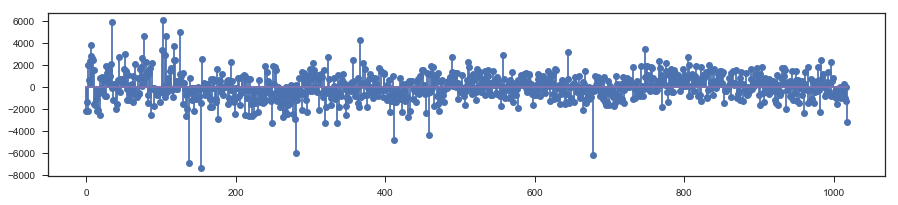

In [80]:
plt.figure(figsize=(15, 3))
plt.stem(model_ols.resid)
plt.show()

In [81]:
# resid_student 절대값 2 초과하는 data들 44개 (제거 검토 후보군)
DF[abs(DF.resid_student) > 2].shape

(44, 10)

In [82]:
# 레버리지 ( HAT ) 분석 : X 값에 대하여 이상치 파악   
# 일반적 (2k+2)/n 을 넘으면 주의해야 함 (k: 예측 변수의 개수 n: 관찰값(데이터)의 개수) 
# 현재 model의 k= 5, n = 1019 -> 12/1019 = 0.01177625122669283611383709519136 가 기준이 됨

In [83]:
print '-'*30 + ' Leverage ' + '-'*30
print DF.leverage.describe()
print '\n'
print '-'*30 + ' top 5 highest leverage data points ' + '-'*30
print DF.sort_values(by = 'leverage', ascending = False).head()

------------------------------ Leverage ------------------------------
count    1019.000000
mean        0.004907
std         0.007774
min         0.001154
25%         0.002165
50%         0.002806
75%         0.004541
max         0.156500
Name: leverage, dtype: float64


------------------------------ top 5 highest leverage data points ------------------------------
      Id  Price      KM  Weight  Mfg_Year  Automatic_airco     cooks  \
154  223  12450   74172    1615      2001                0  1.538610   
678  964   9390   50806    1480      1999                0  0.661546   
77   112  31000    4000    1480      2004                1  0.227305   
134  188   6950  243000    1110      2001                0  0.037984   
101  140  23000   25000    1320      2003                0  0.050764   

       dffits  leverage  resid_student  
154 -2.830748  0.156500      -6.571836  
678 -1.843072  0.107035      -5.323486  
77   1.073342  0.071940       3.855160  
134 -0.436602  0.038549      -2.18

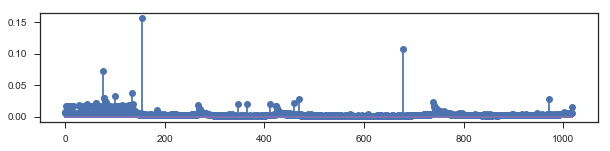

In [84]:
hat = influence.hat_matrix_diag
plt.figure(figsize=(10, 2))
plt.stem(hat)
plt.show()

In [85]:
# 영향력 측정하는 방법? DFFITS와 COOK's DISTANCE
# 2가지 모두 잔차와 레버리지 정보를 조합하여 측정하는 것. (scale 방식은 다르나, 매우 유사하며 결과도 비슷)

In [86]:
#3. DFFITS : 추정치 ( y_hat ) 에 대한 영향력 파악
# 양수와 음수로 값이 나올수 있음. 0에 가까울수록 영향력이 작음  
# 일반적인 cut-off point 2*sqrt(k/n). 

In [87]:
#4. COOK'S DISTANCE : ( X의 ) 회귀계수에 대한 종합적 영향력 평가
# 값의 범위: 0부터 / 값이 클수록 큰 영향력 가짐 
# 일반적인 cut-off point 4/n. 

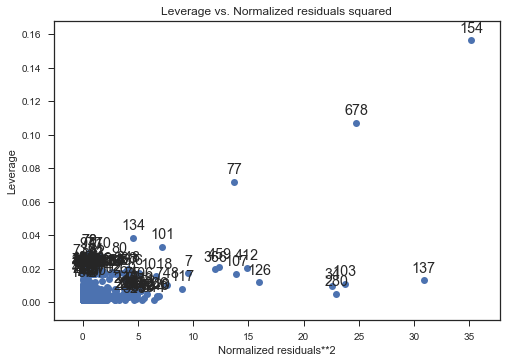

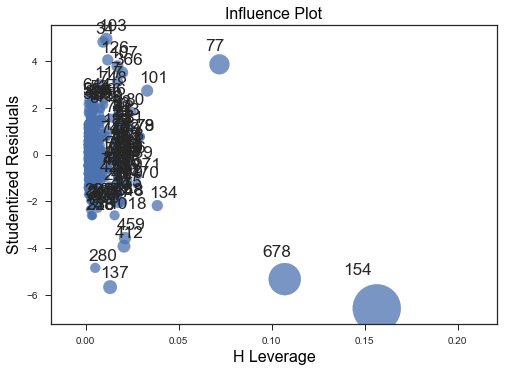

In [88]:
# 잔차에 곱과 레버리지 제곱의 plot (양쪽 모두 높은 값을 가진 점은 영향력이 큼, 제곱을 하는 이유는 음수를 양수로)
from statsmodels.graphics.regressionplots import *
plot_leverage_resid2(model_ols)
plt.show()

influence_plot(model_ols) # Cook's distance를 버블 크기로 표시
plt.show()

In [89]:
# DIFFS 기준
DF[abs(DF.dffits) > 2 * math.sqrt(5.0 / 1019)].dffits.sort_values(ascending=False).head()

77     1.073342
103    0.523843
101    0.505406
107    0.497684
366    0.496715
Name: dffits, dtype: float64

In [90]:
# Cook's distance 
# 일반적으로 평균의 3배이상의 값을 가지면 이상치로 의심.
# 다른 해석은 4 / n 이상 이거나, Cook's Dist.값이 1 (또는 0.5)보다 점이 영향력있는 점. 
# 박사님 강의안 Fox recommentation  기준 4 / (N−K−1)
Cook_mean = DF.cooks.mean()
print DF[(DF.cooks > 3 * Cook_mean)]
print '\n'
print DF[(DF.cooks > 0.5)] 

        Id  Price      KM  Weight  Mfg_Year  Automatic_airco     cooks  \
5       14  21500   23000    1185      2002                1  0.013191   
6       16  22000   18739    1185      2002                1  0.018373   
7       17  22750   34000    1185      2002                1  0.033791   
34      54  21950   49866    1195      2002                0  0.043177   
77     112  31000    4000    1480      2004                1  0.227305   
80     116  22950   10000    1270      2004                0  0.016982   
87     126  16950   36012    1130      2003                1  0.015577   
88     127  21750   36000    1130      2003                1  0.011468   
101    140  23000   25000    1320      2003                0  0.050764   
103    143  23950   21684    1185      2003                0  0.053643   
107    149  24500   19988    1130      2003                1  0.048900   
117    163  20750   10000    1105      2003                0  0.014404   
126    173  23750   11000    1130     

In [91]:
# Case A. Cook's distance 값 Cook's Dis.의 3배를 초과하는 점 제외
data1 = DF[(DF.cooks <= 3 * Cook_mean)]
print data1.shape
# Case B. Cooks' distance 값 0.5 초과하는 2점만(Id: 223, 964) 제외
data2 = DF[(DF.cooks <= 0.5)]
print data2.shape

(994, 10)
(1017, 10)


In [92]:
model_ols1 =  smf.ols("Price ~ KM + Weight + Mfg_Year + Automatic_airco", data1).fit()
print model_ols1.summary()
# 기존 model 대비 Adjusted R-squared 증가. 0.880 -> 0.902

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     2285.
Date:                Fri, 30 Jun 2017   Prob (F-statistic):               0.00
Time:                        11:57:38   Log-Likelihood:                -8317.5
No. Observations:                 994   AIC:                         1.664e+04
Df Residuals:                     989   BIC:                         1.667e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.728e+06   6.43e+04    -

In [93]:
model_ols2 = smf.ols("Price ~ KM + Weight + Mfg_Year + Automatic_airco", data2).fit()
print model_ols2.summary()
# 기존 model 대비 Adjusted R-squared 증가. 0.880 -> 0.890

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                     2048.
Date:                Fri, 30 Jun 2017   Prob (F-statistic):               0.00
Time:                        11:57:59   Log-Likelihood:                -8653.0
No. Observations:                1017   AIC:                         1.732e+04
Df Residuals:                    1012   BIC:                         1.734e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.707e+06    7.1e+04    -

### 6. 회귀모형 가정의 진단 및 개선

In [94]:
#1 선형성 검토 : 독립변수에 대한 잔차를 통해 선형여부 판단 ( X 를 대수 및 지수 변환 등으로 해결 )
# 선형성은 그래프를 보고 판단

In [95]:
# Case A 
DF_res1 = pd.concat([data1[attributes], pd.Series(model_ols1.resid, name = 'resid')], axis = 1)
DF_res1.shape

(994, 5)

In [96]:
# Case B
DF_res2 = pd.concat([data2[attributes], pd.Series(model_ols2.resid, name = 'resid')], axis = 1)
DF_res2.shape

(1017, 5)

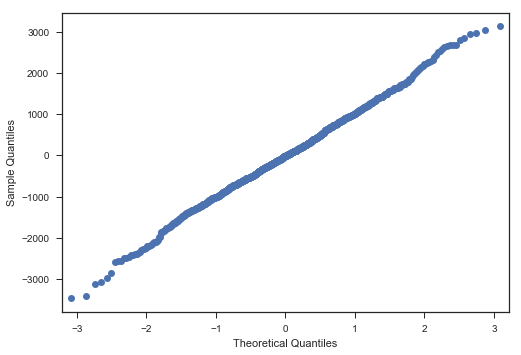

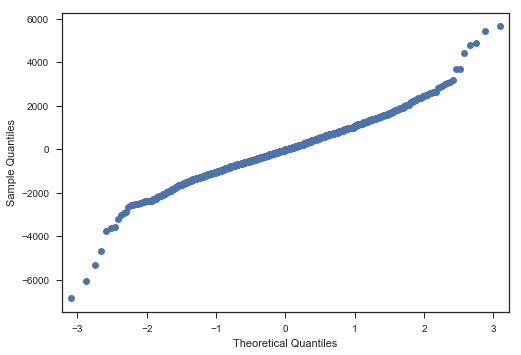

In [97]:
# QQ plot을 그려봄. 대각선으로 일직선이면 정규성
sm.qqplot(DF_res1.resid)
sm.qqplot(DF_res2.resid)
plt.show()

In [98]:
print scipystats.shapiro(DF_res1['resid'])
print scipystats.shapiro(DF_res2['resid'])

(0.9977421164512634, 0.1944519728422165)
(0.9692628383636475, 7.650419875512501e-14)


QQ-plot 및 shapiro wilk test 를 통해 잔차의 정규성을 검증해본 결과  
Cook's distance 값 3 초과하는 영향력을 가진 점 제외한 Case A 만이 정규성을 만족함.

In [99]:
#2. 등분산성 검토 : y_hat 에 대한 잔차를 통해 등분산성 판단 (y 를 대수 및 제곱근 변환 등으로 해결 )
# 모델이 잘 fit되어 있다면, 잔차의 plot에 pattern이 없어야한다.  
# 만약 잔차의 분산이 일정하지 않다면, 이분산이라고 한다. (등분산성이 깨짐)  

In [100]:
print model_ols1.predict().shape
print model_ols2.predict().shape

(994,)
(1017,)


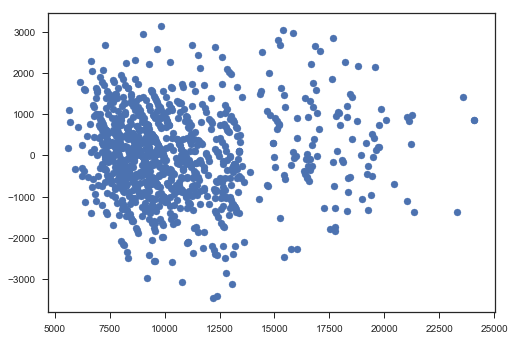

In [101]:
# 잔차와 예측값의 산포도 
print plt.scatter(model_ols1.predict(), model_ols1.resid)

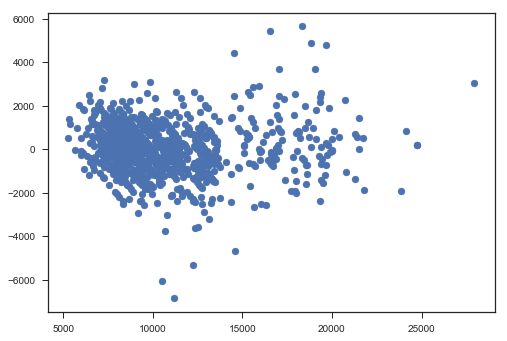

In [102]:
print plt.scatter(model_ols2.predict(), model_ols2.resid)

정규성을 검정과 유사하게 등분산성 검정에서도,  
Cook's distance 값 3 초과하는 영향력을 가진 점 제외한 Case A가 Case B 보다 상대적으로 등분산성을 지닌 것으로 보임.

In [103]:
#3. 독립성 검토 : 오차항 error 들은 서로 독립
# Durbin Watson? 0에 가까울수록 양의 자기상관 / 2에 가까울수록 자기상관 없음 / 4에 가까울수록 음의 자기상관 

In [104]:
print stools.durbin_watson(model_ols1.resid)
print stools.durbin_watson(model_ols2.resid)

1.7746922606
1.66898145072


두 경우 모두 각각 1.78과 1.67로 2에 가깝다. 즉 독립성 가정은 만족한다고 볼 수 있을 것.  
하지만, 위 2개와 마찬가지로 data1을 활용한 경우가 보다 자기상관이 없다
따라서, data1만을 활용함.

### 7. 다중공선성 진단 (Multicollinearity)

In [105]:
# 1. (피어슨) 상관행렬을 통해 대략적인 파악
corrmat_MC1 = data1[attributes].corr()
corrmat_MC1
# Age_08_04, Mfg_Year 강한 음의 상관관계 가진 것으로 보임.

,KM,Weight,Mfg_Year,Automatic_airco
KM,1.000000,0.024153,-0.526909,-0.269965
Weight,0.024153,1.000000,0.492951,0.444067
Mfg_Year,-0.526909,0.492951,1.000000,0.456295
Automatic_airco,-0.269965,0.444067,0.456295,1.000000


In [106]:
# 2. 고유값 ( Eigen vlaue < 30 ) & 분산팽창계수 ( VIF; Variance Inflation Factor < 10 ) 을 통해 검토

In [108]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices("Price ~ KM + Weight + Mfg_Year + Automatic_airco", data = data1, return_type = "dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print vif
# Age_08_04, KM, Mfg_Year -> VIF 10 이상으로 다중 공선성 의심됨.

[3763855.6308538062, 1.6701076928666048, 1.7298594862375014, 2.1916510270498888, 1.4122421711717317]


In [110]:
# Case1: 'Mfg_Year' 대신 'Age_08_04
attributes3 = ['Age_08_04', 'KM', 'Weight', 'Automatic_airco']

In [111]:
corrmat_MC3 = data1[attributes3].corr() 
corrmat_MC3

KeyError: "['Age_08_04'] not in index"

In [155]:
y, X = dmatrices("Price ~ Age_08_04 + KM + Weight + Automatic_airco", data = data1, return_type = "dataframe")
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print vif
# 다중공선성 해소

[1176.8610272021579, 2.1487935327750298, 1.656702405740486, 1.7259134641274618, 1.4170053530921121]


### Case 별 다중회귀분석 실시해서 결과값 비교

In [156]:
# Case1: 'Age_08_04' 제거
model_ols2 = smf.ols("Price ~ KM + Weight + Mfg_Year + Automatic_airco", data1).fit()
model_ols2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.903
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     2295.
Date:                Thu, 29 Jun 2017   Prob (F-statistic):               0.00
Time:                        16:43:14   Log-Likelihood:                -8316.8
No. Observations:                 994   AIC:                         1.664e+04
Df Residuals:                     989   BIC:                         1.667e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -2.728e+06   6.42e+04    -42.470      0.000   -2.85e+06    -2.6e+06
KM                 -0.0192      0.001    -16.600      0.000      -0.021      -0.017
Weight             16.2736      1.019     15.964      0.000      14.273      18.274
Mfg_Year         1361.3076     32.369     42.056      0.000    1297.787    1424.828
Automatic_airco  2467.7933    177.394     13.911      0.000    2119.681    2815.906
==============================================================================
Omnibus:                        2.144   Durbin-Watson:                   1.775
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                2.202
Skew:                          -0.002   Prob(JB):                        0.332
Kurtosis:                       3.231   Cond. No.                     1.51e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [157]:
# Case2: 'Mfg_Year' 제거
model_ols3 = smf.ols("Price ~ Age_08_04 + KM + Weight + Automatic_airco", data1).fit()
model_ols3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.893
Method:                 Least Squares   F-statistic:                     2075.
Date:                Thu, 29 Jun 2017   Prob (F-statistic):               0.00
Time:                        16:43:58   Log-Likelihood:                -8361.7
No. Observations:                 994   AIC:                         1.673e+04
Df Residuals:                     989   BIC:                         1.676e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        -120.9832   1188.164     -0.102      0.919   -2452.595    2210.629
Age_08_04        -108.8644      2.783    -39.120      0.000    -114.325    -103.403
KM                 -0.0203      0.001    -16.801      0.000      -0.023      -0.018
Weight             16.9550      1.065     15.917      0.000      14.865      19.045
Automatic_airco  2612.9978    185.165     14.112      0.000    2249.636    2976.359
==============================================================================
Omnibus:                        2.300   Durbin-Watson:                   1.841
Prob(Omnibus):                  0.317   Jarque-Bera (JB):                2.396
Skew:                          -0.000   Prob(JB):                        0.302
Kurtosis:                       3.241   Cond. No.                     2.67e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Case2의 경우 Intercept의 Pvalue 값이 0.919로 높고 Adjusted R값도 Case1의 경우보다 낮음.  
-> Case1로 결정

### 8. 최종 회귀함수 결정

#### Cross Validation 실시

In [113]:
from sklearn.model_selection import train_test_split
# train - 75% test - 25% 나뉨
X_train, X_test, y_train, y_test = train_test_split(data1[attributes], data1["Price"], random_state = 1) # random_state는 seed 값(크게 의미 x)

In [114]:
from sklearn.model_selection import cross_val_score
model = linear_model.LinearRegression()
scores = cross_val_score(model, X_train, y_train, cv=10) # 여기서의 score 값은 r square 값
print scores
print scores.mean()

[ 0.90993682  0.92362273  0.90445226  0.89457093  0.92624711  0.81297522
  0.92482955  0.76577068  0.89135334  0.8385381 ]
0.879229673176


#### Predition

In [115]:
test = pd.read_csv("test.csv")
test.shape

(417, 38)

In [117]:
model_fin = linear_model.LinearRegression()
model_fin.fit(data1[attributes], data1.Price)
model_fin.coef_

array([ -1.93884943e-02,   1.65343657e+01,   1.36142654e+03,
         2.38388645e+03])

In [124]:
Predicted_price = model_fin.predict(test[attributes])

In [129]:
# 9. 'Age_08_04' 제거
attributes = ['KM', 'Weight', 'Mfg_Year', 'Automatic_airco']
M10 = lm.fit(data1[attributes], data1.Price)
# M8 모델의 성적 (slightly worse than M8) 
M10.score(data1[attributes], data1.Price)

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(data1.Price, M10.predict(data1[attributes]))
rmse = np.sqrt(mse)
rmse

1041.8587073349063

#### CSV file 생성

In [121]:
import csv
with open('answer_datamacho.csv', 'wb') as csvfile:
    fieldnames = ['Id', 'Price']
    writer =  csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(test.Id)): 
        writer.writerow({'Id' : test.Id[i], 'Price' : Predicted_price[i]})